In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import sys
import json
import glob
import torch

import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot

import networkx

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
INPUT_DIR = '../kcg-ml-image-pipeline/output/environmental/ranking_v1/'
PMT_PATH = 'data/environmental/prompt.json'

# EMB_PATH = 'data/environmental/clip_text_emb.npz'
# WEIGHT_DIR = 'weight/021/environmental/clip_text/'

EMB_PATH = 'data/environmental/clip_vision_emb.npz'
WEIGHT_DIR = 'weight/021/environmental/clip_vision/'

BATCH_SIZE = 1024

NUM_MODELS = 16

NUM_FEATURES = 512

LR = 1e-3

# load emb

In [3]:
data = np.load(EMB_PATH, allow_pickle=True)

file_paths = data['file_paths']
path_to_index = {file_path.split('_')[0]: i for i, file_path in enumerate(file_paths)}

# load rank data

In [4]:
paths = sorted(glob.glob(os.path.join(INPUT_DIR, 'ranking_data', '*.json')))

rank_pairs = list()
for path in tqdm(paths):
    js = json.load(open(path))
    
    file_path_1 = os.path.splitext(js['image_1_metadata']['file_path'])[0].replace('datasets/', '')
    file_path_2 = os.path.splitext(js['image_2_metadata']['file_path'])[0].replace('datasets/', '')
    
    if (file_path_1 not in path_to_index) or (file_path_2 not in path_to_index):
        continue
    rank_pairs.append((file_path_1, file_path_2, js['selected_image_index']))

  0%|          | 0/49097 [00:00<?, ?it/s]

# build rank network

In [5]:
graph = networkx.DiGraph()

In [6]:
for img_1, img_2, sel_id in rank_pairs:
    if sel_id == 0:
        graph.add_edge(img_2, img_1)
    else:
        graph.add_edge(img_1, img_2)
len(graph.nodes), len(graph.edges)

(30946, 49072)

## check conflicts

In [7]:
cycles = list(networkx.simple_cycles(graph))
len(cycles)

3

## split samples

In [8]:
subgraphs = list(networkx.weakly_connected_components(graph))
len(subgraphs)

341

In [9]:
subgraph = graph.subgraph(subgraphs[0])
len(subgraph.nodes), len(subgraph.edges)

(30224, 48690)

In [10]:
from metis import part_graph

In [11]:
(edgecuts, parts) = part_graph(subgraph, NUM_MODELS, ncuts=1, niter=10)

In [12]:
nodes = np.array(list(subgraph.nodes.keys()))
parts = np.array(parts)

split_nodes = list()
split_edges = list()

for i in range(NUM_MODELS):

    nodes_i = set(nodes[parts == i])

    edges_i = list()
    for node_0, node_1 in subgraph.edges.keys():
        if node_0 not in nodes_i or node_1 not in nodes_i:
            continue
        edges_i.append((node_0, node_1))

    split_nodes.append(nodes_i)
    split_edges.append(edges_i)

In [13]:
np.mean(list(map(len, split_edges)))

1010.0

# build dataset

In [14]:
rank_pairs = pd.DataFrame(rank_pairs, columns=['image_1', 'image_2', 'selected_image_index'])

In [15]:
ordered_pairs = [((image_1, image_2) if selected_image_index == 0 else (image_2, image_1)) for image_1, image_2, selected_image_index in rank_pairs.itertuples(index=False, name=None)]
ordered_pairs = pd.DataFrame(ordered_pairs, columns=['image_1', 'image_2'])

In [16]:
split_edges = list()
for nodes_i in split_nodes:
    edges_i = ordered_pairs.query('image_1 in @nodes_i and image_2 in @nodes_i')
    split_edges.append(edges_i)

In [18]:
# positive_pooler_outputs = data['positive_pooler_outputs']
# negative_pooler_outputs = data['negative_pooler_outputs']

image_embeds = data['image_embeds']

## build feature

In [19]:
def build_feature(index_1, index_2, pooling_method, use_positive=True, use_negative=False):
    
    if pooling_method == 'pooler_outputs':
        pos_features = positive_pooler_outputs
        neg_features = negative_pooler_outputs
    elif pooling_method == 'image_embeds':
        pos_features = image_embeds
    
    results = list()
    if use_positive:
        results.append(np.stack([pos_features[index_1], pos_features[index_2]], axis=-1))
    if use_negative:
        results.append(np.stack([neg_features[index_1], neg_features[index_2]], axis=-1))
        
    if len(results) == 1:
        return results[0]
    else:
        return np.concatenate(results, axis=0)

In [20]:
val_indices = ordered_pairs.index.difference(sum([list(i.index) for i in split_edges], start=[]))

In [22]:
use_positive = True
use_negative = False
pooling_method = 'image_embeds'

train_datas = list()
for edges_i in split_edges:
    train_data = list()
    for image_1, image_2 in edges_i.itertuples(index=False, name=None):
        index_1, index_2 = path_to_index[image_1], path_to_index[image_2]
        train_data.append(build_feature(index_1, index_2, pooling_method, use_positive=use_positive, use_negative=use_negative))
    train_datas.append(np.stack(train_data, axis=0))

val_data = list()
for image_1, image_2 in ordered_pairs.loc[val_indices].itertuples(index=False, name=None):
    index_1, index_2 = path_to_index[image_1], path_to_index[image_2]
    val_data.append(build_feature(index_1, index_2, pooling_method, use_positive=use_positive, use_negative=use_negative))
val_data = np.stack(val_data, axis=0)

In [23]:
val_dataset = torch.tensor(val_data).half()#.cuda()

# build model

In [24]:
def train_model(model, train_data, feature_selection=None):
    
    if feature_selection is not None:
        train_data = train_data[..., feature_selection, :]
    train_dataset = torch.tensor(train_data).half().cuda()
    
    model = model.cuda()
    
    parameters = list(model.parameters())

    optimizer = torch.optim.Adam(parameters, lr=LR, weight_decay=1e-3)
    
    scaler = torch.cuda.amp.GradScaler()

    for epoch in tqdm(range(500), leave=False):

        bces, accs = list(), list()

        model.train()

        label = torch.zeros((train_dataset.shape[0],), device='cuda')

        x = train_dataset

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(True):

            y0 = model(x[..., 0])
            y1 = model(x[..., 1])

            y = torch.concat([y0, y1], dim=-1)

        # backward

        bce = torch.nn.functional.cross_entropy(y, label.long())

        acc = (y0 > y1).float().mean()

        l1 = torch.norm(model.weight, p=1)

        loss = bce + l1 * 1e-2

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bces.append(bce.detach().cpu().numpy())
        accs.append(acc.detach().cpu().numpy())

    model.eval()

    val_bces, val_accs = list(), list()

    with torch.no_grad():

        with torch.cuda.amp.autocast(True):

            for i in range(0, val_dataset.shape[0], BATCH_SIZE):

                x = val_dataset[i:i+BATCH_SIZE].cuda()
                if feature_selection is not None:
                    x = x[..., feature_selection, :]

                y0 = model(x[..., 0])
                y1 = model(x[..., 1])

                y = torch.concat([y0, y1], dim=-1)

                label = torch.zeros((y.shape[0],), device='cuda').long()

                bce = torch.nn.functional.cross_entropy(y, label)

                acc = (y.argmax(dim=-1) == 0).float().mean()

                val_bces.append(bce.detach().cpu().numpy())
                val_accs.append(acc.detach().cpu().numpy())
    
    print(f'{np.mean(bces):.4f} {np.mean(accs):.4f} {np.mean(val_bces):.4f} {np.mean(val_accs):.4f}')

In [25]:
def inference(models, data, feature_selections=None):
    
    results = list()
    
    for model, feature_selection in zip(models, feature_selections):
        
        model.cuda()
        model.eval()

        ys = list()

        with torch.no_grad():

            with torch.cuda.amp.autocast(True):

                for i in range(0, data.shape[0], BATCH_SIZE):

                    x = data[i:i+BATCH_SIZE].cuda()
                    if feature_selection is not None:
                        x = x[..., feature_selection]

                    y = model(x)

                    ys.append(y.detach().cpu().numpy())
        
        ys = np.concatenate(ys, axis=0)
        results.append(ys)
        
    results = np.concatenate(results, axis=-1)
    
    return results

# train model

In [26]:
models = list()
feature_selections = list()

for i, train_data in enumerate(train_datas):
    
    print(i)
    
    if NUM_FEATURES > 0:
        n_features = NUM_FEATURES
        feature_selection = np.array(sorted(np.random.choice(val_data.shape[1], NUM_FEATURES, False)))
    else:
        n_features = val_data.shape[1]
        feature_selection = None
        
    model = torch.nn.Linear(n_features, 1, bias=True)
    
    model = model.cuda()
    
    train_model(model, train_data, feature_selection)
    
    model = model.cpu()
    
    models.append(model)
    feature_selections.append(feature_selection)

0


  0%|          | 0/500 [00:00<?, ?it/s]

0.2106 0.9252 0.2254 0.9104
1


  0%|          | 0/500 [00:00<?, ?it/s]

0.2399 0.9064 0.2295 0.9151
2


  0%|          | 0/500 [00:00<?, ?it/s]

0.2365 0.9103 0.2286 0.9139
3


  0%|          | 0/500 [00:00<?, ?it/s]

0.2302 0.9192 0.2256 0.9163
4


  0%|          | 0/500 [00:00<?, ?it/s]

0.2479 0.9137 0.2341 0.9139
5


  0%|          | 0/500 [00:00<?, ?it/s]

0.2347 0.9040 0.2318 0.9091
6


  0%|          | 0/500 [00:00<?, ?it/s]

0.2437 0.9292 0.2306 0.9152
7


  0%|          | 0/500 [00:00<?, ?it/s]

0.2255 0.9081 0.2222 0.9170
8


  0%|          | 0/500 [00:00<?, ?it/s]

0.2656 0.8889 0.2349 0.9136
9


  0%|          | 0/500 [00:00<?, ?it/s]

0.2197 0.9120 0.2248 0.9125
10


  0%|          | 0/500 [00:00<?, ?it/s]

0.2454 0.9130 0.2296 0.9144
11


  0%|          | 0/500 [00:00<?, ?it/s]

0.2418 0.9071 0.2347 0.9111
12


  0%|          | 0/500 [00:00<?, ?it/s]

0.2224 0.9241 0.2199 0.9160
13


  0%|          | 0/500 [00:00<?, ?it/s]

0.2220 0.9269 0.2286 0.9092
14


  0%|          | 0/500 [00:00<?, ?it/s]

0.2556 0.8898 0.2341 0.9142
15


  0%|          | 0/500 [00:00<?, ?it/s]

0.2400 0.9101 0.2308 0.9124


# save model

In [28]:
os.makedirs(WEIGHT_DIR, exist_ok=True)

In [29]:
for i, (model, feature_selection) in enumerate(zip(models, feature_selections)):
    torch.save(model.state_dict(), os.path.join(WEIGHT_DIR, f'{i}.pt'))
    if feature_selection is not None:
        np.save(os.path.join(WEIGHT_DIR, f'{i}.npy'), feature_selection)

# analysis

## val set distribution

In [50]:
x = val_dataset

val_y0 = inference(models, x[..., 0], feature_selections)
val_y1 = inference(models, x[..., 1], feature_selections)

val_mean, val_std = val_y0.mean(axis=0, keepdims=True), val_y0.std(axis=0, keepdims=True)
val_y0 = (val_y0 - val_mean) / val_std
val_y1 = (val_y1 - val_mean) / val_std

val_delta = val_y0.mean(axis=-1) - val_y1.mean(axis=-1)# - (val_y0.var(axis=-1) + val_y1.var(axis=-1)) / 2

/home/xhxie/snap/kk-digital/kcg-ml-image-pipeline/venv/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


0.9129391758525401


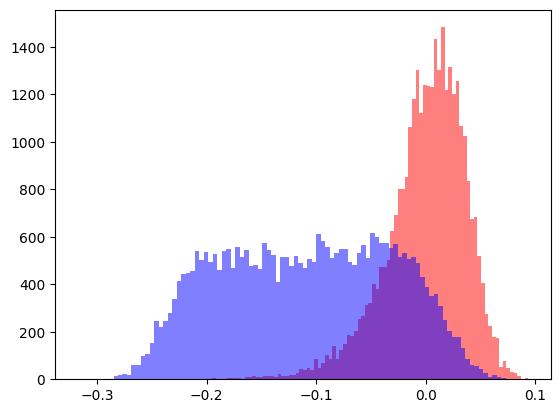

In [51]:
y0, y1, delta = val_y0.mean(axis=-1), val_y1.mean(axis=-1), val_delta

print((y0 > y1).mean())

_ = pyplot.hist(y0, bins=100, color='r', alpha=0.5)
_ = pyplot.hist(y1, bins=100, color='b', alpha=0.5)
# _ = pyplot.hist(delta, bins=100, color='y', alpha=0.5)

In [52]:
- torch.log(torch.sigmoid(torch.tensor(delta).float())).mean()

tensor(0.6408)

In [54]:
# exp0 = np.exp(y0)
# exp1 = np.exp(y1)

exp0 = np.exp(y0 + val_y0.var(axis=-1) / 2)
exp1 = np.exp(y1 + val_y1.var(axis=-1) / 2)

- torch.log(torch.tensor(exp0 / (exp0 + exp1)).float()).mean()

tensor(0.7014)

## score distribution

In [37]:
score = inference(models, torch.tensor(image_embeds).half(), feature_selections).astype('float32')
# score = inference(models, torch.tensor(np.concatenate([positive_pooler_outputs, negative_pooler_outputs], axis=-1)).half(), feature_selections).astype('float32')

In [38]:
sigma_score = (score - score.mean(axis=0, keepdims=True)) / score.std(axis=0, keepdims=True)

In [39]:
sigma_score_mean, sigma_score_var = sigma_score.mean(axis=-1), sigma_score.var(axis=-1)
sigma_score_max, sigma_score_min = sigma_score.max(axis=-1), sigma_score.min(axis=-1)

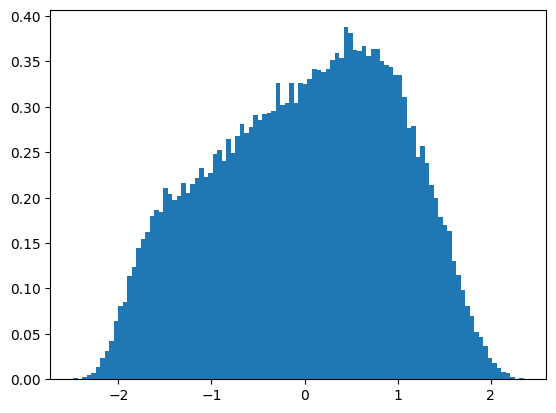

In [40]:
_ = pyplot.hist(sigma_score_mean, bins=100, density=True)
pyplot.show()

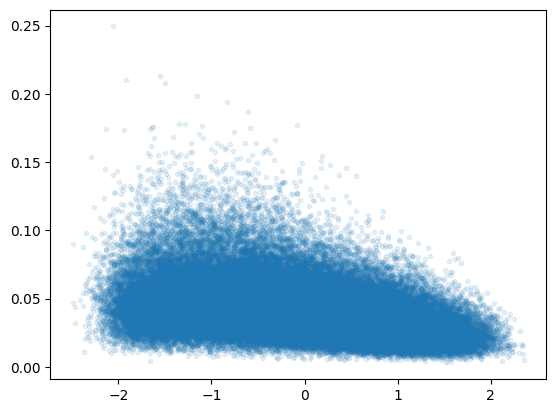

In [42]:
pyplot.plot(sigma_score_mean, sigma_score_var, '.', alpha=0.1)

# entropy

In [33]:
def get_bins(min_value: float, max_value: float, n_bins: int):
    
    bins = np.linspace(min_value, max_value, n_bins)
    
    return bins

def score_to_category(sigma_scores: np.ndarray, bins: np.ndarray):
    
    return np.digitize(sigma_scores, bins)

def get_entropy(categories: np.ndarray):
    
    n_bins = int(categories.max()) + 1
    
    one_hot = np.eye(n_bins)[categories].sum(axis=-2)
    
    probabilities = one_hot / one_hot.sum(axis=-1, keepdims=True)
    
    entropy = - (probabilities * np.log2(probabilities + 1e-7)).sum(axis=-1)
    
    return entropy

In [34]:
bins = get_bins(-2, 1.5, 15, True)
category = score_to_category(score, bins)
entropy = get_entropy(category)

Text(0.5, 1.0, 'relation between entropy and sigma_score_var')

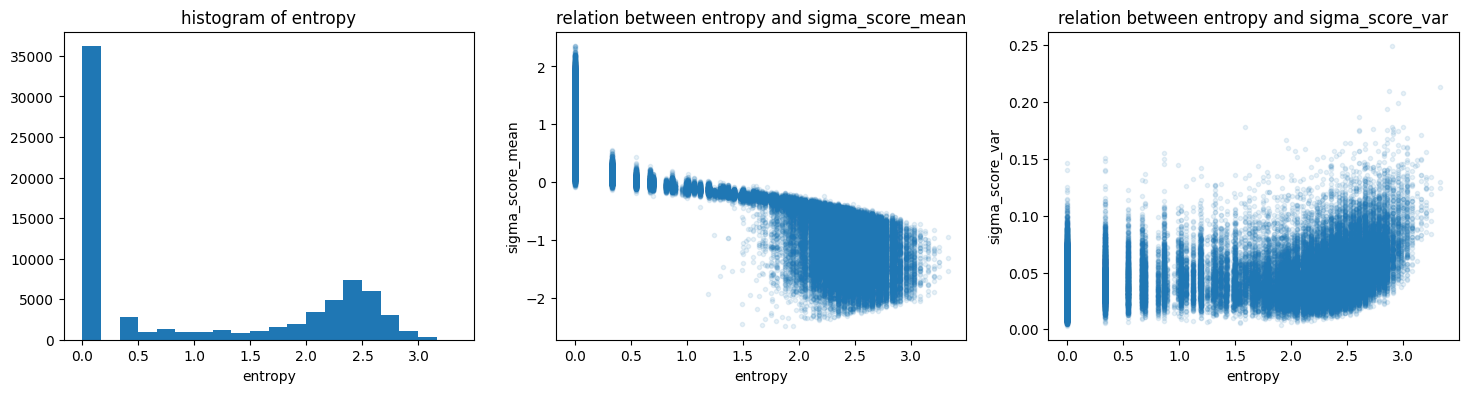

In [43]:
pyplot.figure(figsize=(18, 4))

pyplot.subplot(1, 3, 1)

pyplot.hist(entropy, bins=20)
pyplot.xlabel('entropy')
pyplot.title('histogram of entropy')

pyplot.subplot(1, 3, 2)

pyplot.plot(entropy, sigma_score_mean, '.', alpha=0.1)
pyplot.xlabel('entropy')
pyplot.ylabel('sigma_score_mean')
pyplot.title('relation between entropy and sigma_score_mean')

pyplot.subplot(1, 3, 3)

pyplot.plot(entropy, sigma_score_var, '.', alpha=0.1)
pyplot.xlabel('entropy')
pyplot.ylabel('sigma_score_var')
pyplot.title('relation between entropy and sigma_score_var')

# save ensemble results

In [44]:
prompts = json.load(open(PMT_PATH))

In [55]:
path_to_hash = {j['file_path'].split('_')[0]:i for i, j in prompts.items()}
path_to_uuid = {j['file_path'].split('_')[0]: j['job_uuid'] for i, j in prompts.items()}
uuid_to_path = {j: i for i, j in path_to_uuid.items()}

In [47]:
results = pd.DataFrame()
# results['image_hash'] = [path_to_hash.get(i.split('_')[0]) for i in file_paths]
# results['file_path'] = [i.split('_')[0] for i in file_paths]
results['job_uuid'] = [path_to_uuid.get(i.split('_')[0]) for i in file_paths]
results['sigma_score_mean'] = sigma_score_mean
results['sigma_score_var'] = sigma_score_var
results['entropy'] = entropy
# results['sigma_score_max'] = sigma_score_max
# results['sigma_score_min'] = sigma_score_min
results.dropna(inplace=True)

In [48]:
results

,job_uuid,sigma_score_mean,sigma_score_var,entropy
0,62e988cf-afa1-4d51-9502-0bb70ff2cbe7,0.504082,0.037315,-1.442695e-07
1,fcc8d5f2-c6b6-47ef-9a28-76d2bee5e066,1.353614,0.026322,-1.442695e-07
2,1ed07bf6-4e9a-4b5a-ba17-9923df6bd470,1.038318,0.031820,-1.442695e-07
3,b8d0cf2f-3764-4f47-be28-f9633ef27ec4,0.898113,0.026449,-1.442695e-07
4,ea5fa755-6d37-4d1f-82a2-d6cfbd2b06a0,-0.272595,0.015270,1.649397e+00
...,...,...,...,...
75893,bd0a7abe-281d-42e6-94a3-be5f6ee16d28,1.099078,0.024220,-1.442695e-07
75894,e678c5b4-2ca6-40b8-87c8-05fce4cb2158,-0.427275,0.041221,2.126614e+00
75895,65050059-3649-41ba-965e-14697542974c,0.466373,0.025878,-1.442695e-07
75896,d23c6499-b790-4ea5-8813-3b1927686389,-0.457531,0.032122,1.936278e+00


In [49]:
# results.to_csv('./result/2023-11-22-han-ensemble-clip-image-statistics.csv.gz', index=False)
results.to_csv('./result/2023-11-24-han-16-clip-ensemble.csv', index=False)

In [79]:
selected = results.query('sigma_score_mean > 1.25 and sigma_score_std > 0.2').to_csv('2023-11-22-han-16-clip-ensemble-high-std/images.csv', index=False)

# extract images

In [59]:
selected = pd.read_csv('./export-these.csv', header=None)
selected.columns = ['job_uuid', 'sigma_score_mean', 'sigma_score_var', 'entropy']

In [60]:
selected['file_path'] = list(map(uuid_to_path.get, selected['job_uuid']))

In [62]:
SAVE_DIR = './export-these/'
INPUT_DIR = '../kcg-ml-image-pipeline/output/dataset/image/'

for file_path, job_uuid in zip(selected['file_path'], selected['job_uuid']):
    
    input_path = os.path.join(INPUT_DIR, f'{file_path}.jpg')
                                                               
    # output_dir = os.path.split(os.path.join(SAVE_DIR, f'{file_path}.jpg'))[0]
    output_path = os.path.join(SAVE_DIR, f'{job_uuid}.jpg')
    
    os.makedirs(os.path.split(output_path)[0], exist_ok=True)
    
    os.system(f'cp {input_path} {output_path}')

## prepare for visualization

In [63]:
def select_samples(indices, n_select):
    
    selected = np.random.choice(indices, n_select, False)
    
    selected_file_paths = [file_paths[i] for i in selected]
    selected_file_paths = [i.split('_')[0] + '.jpg' for i in selected_file_paths]
    
    images = np.stack([np.array(Image.open(os.path.join('../kcg-ml-image-pipeline/output/dataset/image/', i))) for i in selected_file_paths])
    images = images.reshape(-1, int(n_select ** 0.5), *images.shape[-3:])
    images = np.concatenate(np.concatenate(images, axis=-3), axis=-2)
    
    images = Image.fromarray(images).resize((512, 512))
    
    return selected, images

## show top score samples

In [71]:
results.query('sigma_score_var > 0.1 and sigma_score_mean > 0.55')

,job_uuid,sigma_score_mean,sigma_score_var,entropy
600,0638122a-2c27-4502-838a-f6d362a15fc0,0.686483,0.107803,-1.442695e-07
14981,0069eb73-e101-4054-9275-d8a93644a86e,0.694243,0.107252,-1.442695e-07
21948,a60d3a2d-0ab9-4eff-9f76-143a339ab29d,0.682320,0.103748,-1.442695e-07
47117,a7d75886-7cc6-4965-92ef-9aa33fe98823,0.558184,0.140007,3.372898e-01
52317,3e531ec8-6f92-495f-a027-d91ccafbef5d,0.829716,0.109844,-1.442695e-07
53379,5ae8d13d-d677-42d9-80db-0ee3c8047f0b,0.683032,0.111231,-1.442695e-07
62943,832a8492-8e0e-4c1f-a084-790d8abcd960,0.847172,0.114056,-1.442695e-07
63964,d849cdb9-569a-4e69-b3f0-1a85392bf0f1,0.550110,0.105738,-1.442695e-07
64993,9e6bf2e9-453e-47d9-99ed-cf2fe2a9d801,0.602418,0.102404,-1.442695e-07
75550,cb6bce56-3ec5-4751-a870-d62506e46c68,0.665627,0.106281,-1.442695e-07


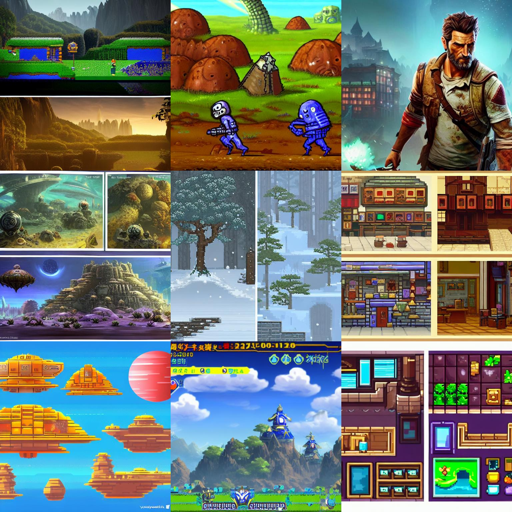

In [73]:
# threshold = np.quantile(mean, q=0.95)
# selected, images = select_samples(np.arange(mean.shape[0])[(mean > threshold)], n_select=9)

indices = results.query('sigma_score_var > 0.1 and sigma_score_mean > 0.55').index
selected, images = select_samples(indices, n_select=9)

images

## show lowest score samples

In [43]:
threshold = np.quantile(mean, q=0.05)
selected, images = select_samples(np.arange(mean.shape[0])[mean < threshold], n_select=9)

threshold

-1.6097631633281708

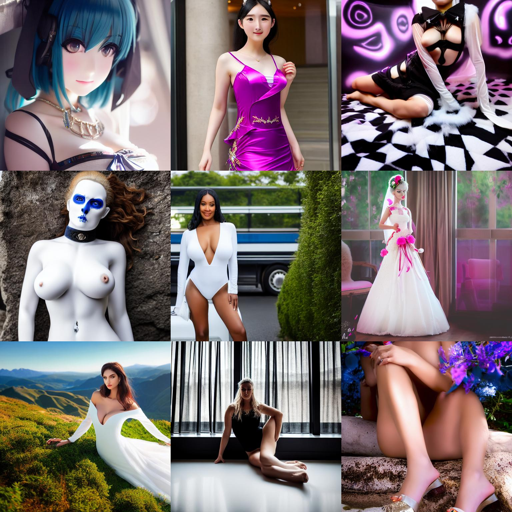

In [44]:
images

## show lowest delta samples

In [41]:
val_pairs = ordered_pairs.loc[val_indices]

In [55]:
n_select = 6

# threshold = np.quantile(val_delta, q=0.05)
# indices = val_pairs.index[np.arange(val_delta.shape[0])[val_delta < threshold]]
# selected = np.random.choice(indices, n_select, False)

selected = val_pairs.index[np.argsort(val_delta)[:n_select]]

indices_1 = [path_to_index[i] for i in val_pairs.loc[selected, 'image_1']]
indices_2 = [path_to_index[i] for i in val_pairs.loc[selected, 'image_2']]

In [56]:
selected_file_paths = [file_paths[i] for i in indices_1]
selected_file_paths = [i.split('_')[0] + '.jpg' for i in selected_file_paths]

images = np.stack([np.array(Image.open(os.path.join('../kcg-ml-image-pipeline/output/dataset/image/', i))) for i in selected_file_paths])
images_1 = np.concatenate(images, axis=-2)

selected_file_paths = [file_paths[i] for i in indices_2]
selected_file_paths = [i.split('_')[0] + '.jpg' for i in selected_file_paths]

images = np.stack([np.array(Image.open(os.path.join('../kcg-ml-image-pipeline/output/dataset/image/', i))) for i in selected_file_paths])
images_2 = np.concatenate(images, axis=-2)

images = np.concatenate([images_1, images_2], axis=-3)

images = Image.fromarray(images).resize((512 * n_select // 2, 512))

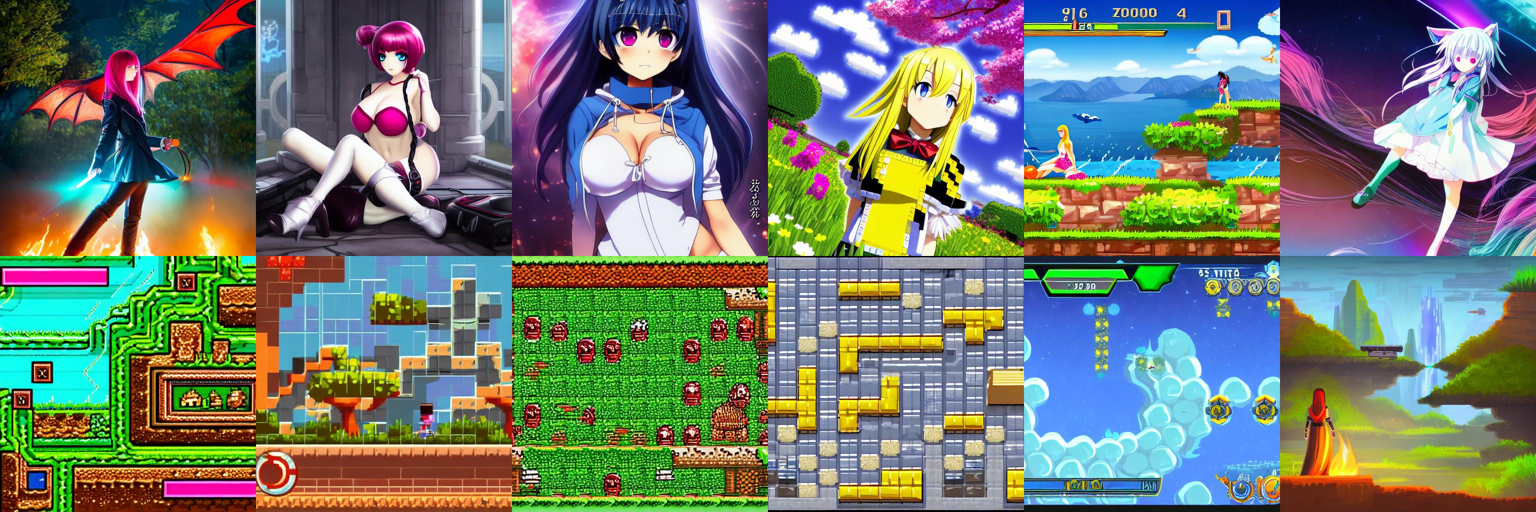

In [57]:
images

In [49]:
def get_bins(min_value: float, max_value: float, n_bins: int, add_inf=False):
    
    bins = np.linspace(min_value, max_value, n_bins)
    
    if add_inf:
        bins = np.array([-np.inf] + list(bins) + [np.inf])
    
    return bins

def score_to_category(sigma_scores: np.ndarray, bins: np.ndarray):
    
    return np.digitize(sigma_scores, bins)

def get_entropy(categories: np.ndarray):
    
    n_bins = int(categories.max()) + 1
    
    one_hot = np.eye(n_bins)[categories].sum(axis=-2)
    
    probabilities = one_hot / one_hot.sum(axis=-1, keepdims=True)
    
    entropy = - (probabilities * np.log2(probabilities + 1e-7)).sum(axis=-1)
    
    return entropy

In [93]:
bins = get_bins(-2, 1.5, 15, True)
category = score_to_category(score, bins)
entropy = get_entropy(category)

Text(0.5, 1.0, 'relation between entropy and sigma_score_std')

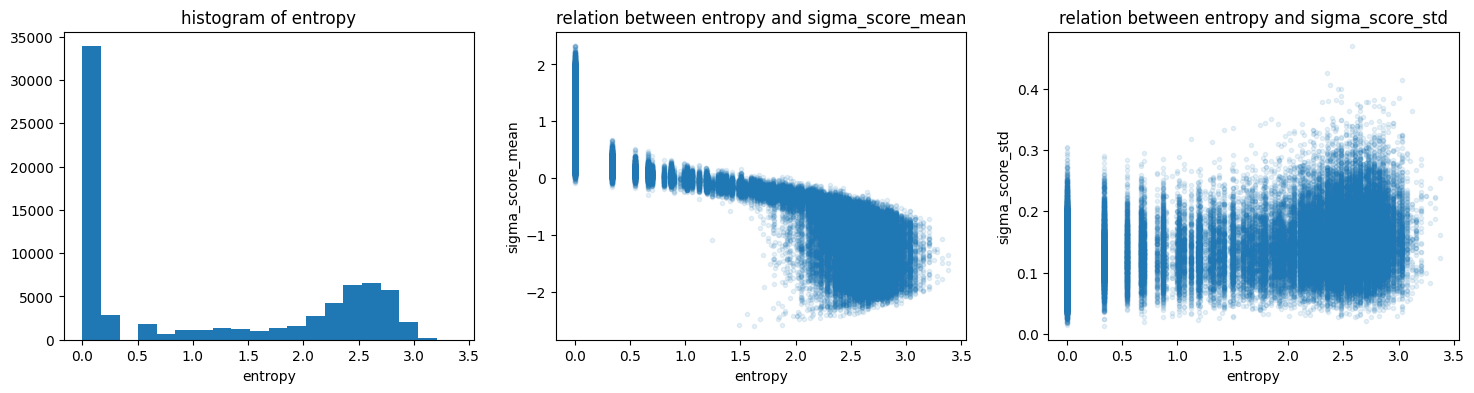

In [94]:
pyplot.figure(figsize=(18, 4))

pyplot.subplot(1, 3, 1)

pyplot.hist(entropy, bins=20)
pyplot.xlabel('entropy')
pyplot.title('histogram of entropy')

pyplot.subplot(1, 3, 2)

pyplot.plot(entropy, sigma_score_mean, '.', alpha=0.1)
pyplot.xlabel('entropy')
pyplot.ylabel('sigma_score_mean')
pyplot.title('relation between entropy and sigma_score_mean')

pyplot.subplot(1, 3, 3)

pyplot.plot(entropy, sigma_score_std, '.', alpha=0.1)
pyplot.xlabel('entropy')
pyplot.ylabel('sigma_score_std')
pyplot.title('relation between entropy and sigma_score_std')